# Chapter 4: SHAP-Based Clustering Analysis

**Research Question**: *"Are there distinct 'archetypes' of firms based on how the model assigns risk, and do these archetypes have meaningfully different default rates?"*

## Motivation:
Previous chapters showed that LightGBM uses 40 features with significant interactions to predict default risk. This chapter investigates whether firms cluster into interpretable groups based on their SHAP value patterns - i.e., groups that are scored similarly by the model.

## Objectives:
1. Cluster firms based on SHAP value patterns (not raw features)
2. Characterize each cluster's risk profile
3. Compute actual default rates per cluster
4. Identify whether distinct "failure modes" or "safety profiles" exist

## Key Insight:
By clustering on SHAP values rather than raw features, we group firms by **how the model perceives them**, not by their objective characteristics. Two firms with very different financials might cluster together if the model assigns them similar risk contributions.

---

In [1]:
import sys
from pathlib import Path
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# UMAP for 2D visualization
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    print("⚠ umap-learn not installed. Run: pip install umap-learn")
    print("  Will use PCA for 2D visualization instead.")
    UMAP_AVAILABLE = False

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Project root: {PROJ_ROOT}")
print(f"UMAP available: {UMAP_AVAILABLE}")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis
UMAP available: True


## 1. Load SHAP Cache and Data

In [2]:
# Load SHAP cache from Chapter 1
cache_file = PROJ_ROOT / "results" / "xai_exploration" / "shap_cache.pkl"

print(f"Loading SHAP cache from: {cache_file}")
with open(cache_file, 'rb') as f:
    shap_cache = pickle.load(f)

# Extract data
X_val = shap_cache['X_val']
y_val = shap_cache['y_val']
y_pred_lgbm = shap_cache['y_pred_proba_lgbm']
y_pred_logit = shap_cache['y_pred_proba_logit']
shap_values_lgbm = shap_cache['shap_values_lgbm']
feature_names = shap_cache['feature_names']

print(f"\n✓ Loaded validation set:")
print(f"  • Observations: {len(X_val):,}")
print(f"  • Features: {len(feature_names)}")
print(f"  • SHAP values shape: {shap_values_lgbm.shape}")
print(f"  • Defaults: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"  • Non-defaults: {(~y_val.astype(bool)).sum():,}")

Loading SHAP cache from: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_exploration/shap_cache.pkl

✓ Loaded validation set:
  • Observations: 60,830
  • Features: 40
  • SHAP values shape: (60830, 40)
  • Defaults: 1,071 (1.76%)
  • Non-defaults: 59,759


## 2. Preprocessing for Clustering

Steps:
1. **Standardize SHAP values** - Scale to unit variance (already centered at ~0)
2. **PCA** - Reduce dimensionality while preserving 95% variance
3. **UMAP** - Create 2D embedding for visualization

In [3]:
# Step 1: Standardize SHAP values
print("Preprocessing SHAP values for clustering...")
print("="*60)

scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_values_lgbm)

print(f"\n1. Standardization:")
print(f"   Original SHAP range: [{shap_values_lgbm.min():.3f}, {shap_values_lgbm.max():.3f}]")
print(f"   Scaled SHAP range: [{shap_scaled.min():.3f}, {shap_scaled.max():.3f}]")
print(f"   Scaled mean: {shap_scaled.mean():.6f} (should be ~0)")
print(f"   Scaled std: {shap_scaled.std():.6f} (should be ~1)")

Preprocessing SHAP values for clustering...

1. Standardization:
   Original SHAP range: [-1.824, 1.620]
   Scaled SHAP range: [-12.084, 48.653]
   Scaled mean: 0.000000 (should be ~0)
   Scaled std: 1.000000 (should be ~1)



2. PCA Dimensionality Reduction:
   Original dimensions: 40
   Reduced dimensions: 34
   Variance explained: 95.5%


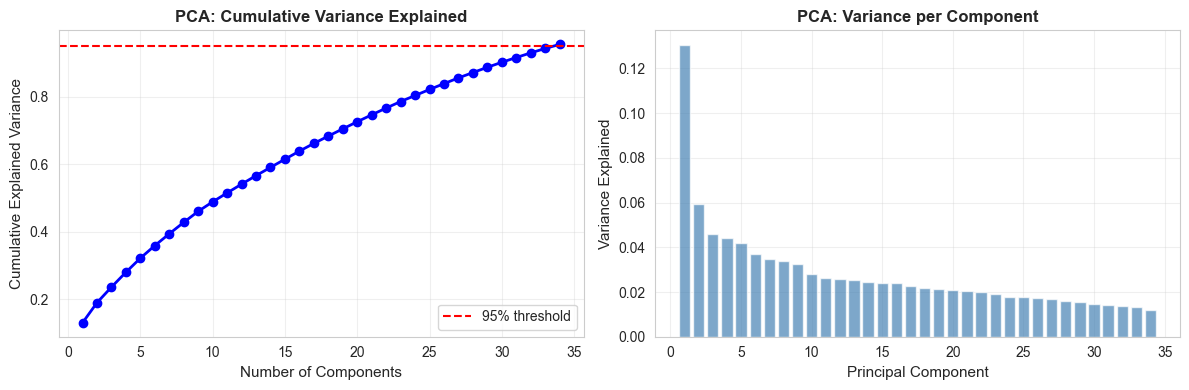


   Top 5 components explain: 32.2% of variance


In [4]:
# Step 2: PCA for dimensionality reduction
print("\n2. PCA Dimensionality Reduction:")

# Fit PCA to capture 95% variance
pca = PCA(n_components=0.95, random_state=42)
shap_pca = pca.fit_transform(shap_scaled)

print(f"   Original dimensions: {shap_scaled.shape[1]}")
print(f"   Reduced dimensions: {shap_pca.shape[1]}")
print(f"   Variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Cumulative variance
cumvar = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(range(1, len(cumvar)+1), cumvar, 'bo-', linewidth=2, markersize=6)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[0].set_xlabel('Number of Components', fontsize=11)
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[0].set_title('PCA: Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Individual variance
axes[1].bar(range(1, len(pca.explained_variance_ratio_)+1), 
            pca.explained_variance_ratio_, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Principal Component', fontsize=11)
axes[1].set_ylabel('Variance Explained', fontsize=11)
axes[1].set_title('PCA: Variance per Component', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n   Top 5 components explain: {cumvar[4]*100:.1f}% of variance")

In [5]:
# Step 3: UMAP for 2D visualization
print("\n3. UMAP 2D Embedding for Visualization:")

if UMAP_AVAILABLE:
    start_time = time.time()
    reducer = umap.UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=15, 
        min_dist=0.1,
        metric='euclidean'
    )
    # Use PCA-reduced data for speed
    shap_2d = reducer.fit_transform(shap_pca)
    elapsed = time.time() - start_time
    print(f"   ✓ UMAP completed in {elapsed:.1f}s")
    print(f"   2D embedding shape: {shap_2d.shape}")
else:
    # Fallback to PCA 2D
    pca_2d = PCA(n_components=2, random_state=42)
    shap_2d = pca_2d.fit_transform(shap_scaled)
    print(f"   ✓ Using PCA 2D instead (UMAP not available)")
    print(f"   2D embedding shape: {shap_2d.shape}")

print("\n" + "="*60)
print("Preprocessing complete!")
print("="*60)


3. UMAP 2D Embedding for Visualization:


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   ✓ UMAP completed in 27.2s
   2D embedding shape: (60830, 2)

Preprocessing complete!


## 3. Determine Optimal Number of Clusters

We test k=2 to 10 and evaluate using:
- **Elbow method**: Inertia (within-cluster sum of squares)
- **Silhouette score**: Measure of cluster cohesion and separation
- **Davies-Bouldin index**: Ratio of within-cluster to between-cluster distances

In [6]:
# Test different values of k
K_range = range(2, 11)

print("Evaluating cluster counts k=2 to k=10...")
print("="*60)

results = []
for k in K_range:
    start = time.time()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(shap_pca)
    
    inertia = kmeans.inertia_
    silhouette = silhouette_score(shap_pca, labels)
    db_index = davies_bouldin_score(shap_pca, labels)
    elapsed = time.time() - start
    
    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'davies_bouldin': db_index,
        'time': elapsed
    })
    
    print(f"  k={k}: Silhouette={silhouette:.4f}, DB={db_index:.4f}, Inertia={inertia:.0f} ({elapsed:.1f}s)")

results_df = pd.DataFrame(results)
print("\n" + "="*60)

Evaluating cluster counts k=2 to k=10...
  k=2: Silhouette=0.1245, DB=2.9248, Inertia=2100226 (20.0s)
  k=3: Silhouette=0.0878, DB=3.4011, Inertia=2025059 (18.6s)
  k=4: Silhouette=0.0619, DB=3.3804, Inertia=1969162 (17.1s)
  k=5: Silhouette=0.0324, DB=3.4296, Inertia=1927188 (16.3s)
  k=6: Silhouette=0.0356, DB=3.3220, Inertia=1890866 (15.9s)
  k=7: Silhouette=0.0290, DB=3.2520, Inertia=1859964 (15.6s)
  k=8: Silhouette=0.0369, DB=2.9657, Inertia=1830613 (15.8s)
  k=9: Silhouette=0.0289, DB=2.9972, Inertia=1805221 (15.5s)
  k=10: Silhouette=0.0326, DB=2.8475, Inertia=1775526 (15.6s)



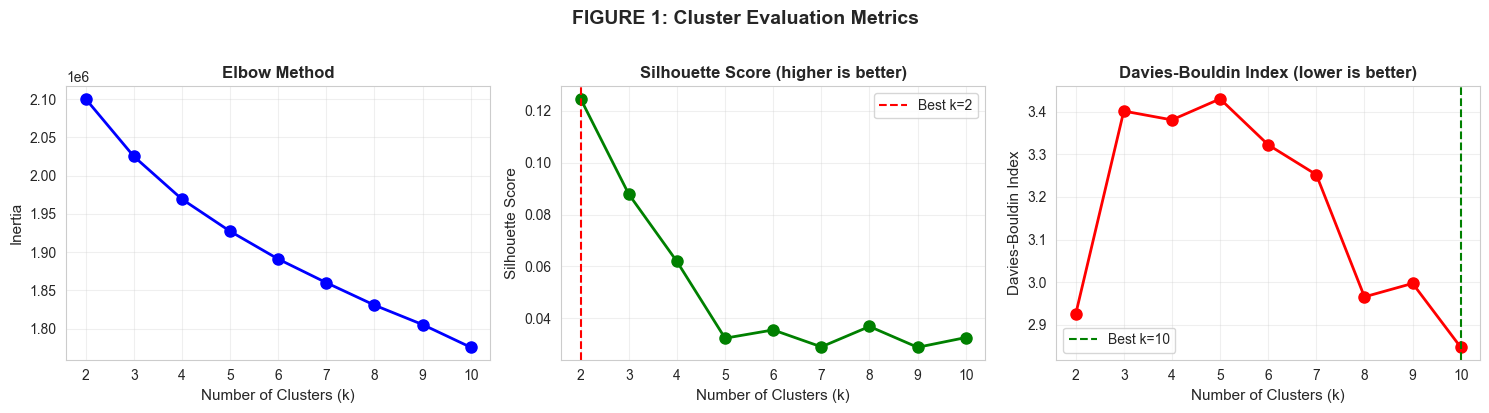


Recommendation:
  • Best k by Silhouette: 2
  • Best k by Davies-Bouldin: 10


In [7]:
# Visualize cluster evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elbow plot
axes[0].plot(results_df['k'], results_df['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Silhouette score (higher is better)
axes[1].plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2, markersize=8)
best_k_silhouette = results_df.loc[results_df['silhouette'].idxmax(), 'k']
axes[1].axvline(x=best_k_silhouette, color='r', linestyle='--', 
                label=f'Best k={best_k_silhouette}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score (higher is better)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Davies-Bouldin index (lower is better)
axes[2].plot(results_df['k'], results_df['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
best_k_db = results_df.loc[results_df['davies_bouldin'].idxmin(), 'k']
axes[2].axvline(x=best_k_db, color='g', linestyle='--', 
                label=f'Best k={best_k_db}')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[2].set_title('Davies-Bouldin Index (lower is better)', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('FIGURE 1: Cluster Evaluation Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nRecommendation:")
print(f"  • Best k by Silhouette: {best_k_silhouette}")
print(f"  • Best k by Davies-Bouldin: {best_k_db}")

In [8]:
# Select optimal k (use silhouette as primary metric, but cap at reasonable number)
# Also consider interpretability - 4-6 clusters are usually most interpretable

# Find best k in interpretable range (3-7)
interpretable_range = results_df[(results_df['k'] >= 3) & (results_df['k'] <= 7)]
k_optimal = int(interpretable_range.loc[interpretable_range['silhouette'].idxmax(), 'k'])

print(f"\nSelected k = {k_optimal}")
print(f"  Silhouette score: {results_df[results_df['k']==k_optimal]['silhouette'].values[0]:.4f}")
print(f"  Davies-Bouldin: {results_df[results_df['k']==k_optimal]['davies_bouldin'].values[0]:.4f}")


Selected k = 3
  Silhouette score: 0.0878
  Davies-Bouldin: 3.4011


## 4. K-Means Clustering

In [9]:
# Fit final K-Means model

k_optimal = 10 # Overwrite with chosen k
print(f"Fitting K-Means with k={k_optimal} clusters...")
print("="*60)

kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(shap_pca)

# Create analysis DataFrame
cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'y_true': y_val.values,
    'pd_lgbm': y_pred_lgbm,
    'pd_logit': y_pred_logit
}, index=X_val.index)

# Add 2D coordinates for visualization
cluster_df['umap_x'] = shap_2d[:, 0]
cluster_df['umap_y'] = shap_2d[:, 1]

# Cluster size summary
cluster_sizes = cluster_df['cluster'].value_counts().sort_index()
print(f"\nCluster Sizes:")
for c, size in cluster_sizes.items():
    print(f"  Cluster {c}: {size:,} firms ({size/len(cluster_df)*100:.1f}%)")

print(f"\n✓ Clustering complete")

Fitting K-Means with k=10 clusters...

Cluster Sizes:
  Cluster 0: 7,266 firms (11.9%)
  Cluster 1: 9,195 firms (15.1%)
  Cluster 2: 2,346 firms (3.9%)
  Cluster 3: 397 firms (0.7%)
  Cluster 4: 10,096 firms (16.6%)
  Cluster 5: 13,502 firms (22.2%)
  Cluster 6: 5,137 firms (8.4%)
  Cluster 7: 3,439 firms (5.7%)
  Cluster 8: 5,833 firms (9.6%)
  Cluster 9: 3,619 firms (5.9%)

✓ Clustering complete


## 5. Cluster Characterization

For each cluster, we analyze:
1. Default rate and predicted PD
2. SHAP value profile (which features drive risk in this cluster)
3. Distinguishing characteristics

In [10]:
# Compute cluster-level statistics
print("="*90)
print("CLUSTER SUMMARY: Default Rates and Predicted Probabilities")
print("="*90)

cluster_summary = cluster_df.groupby('cluster').agg({
    'y_true': ['count', 'sum', 'mean'],
    'pd_lgbm': ['mean', 'median', 'std'],
    'pd_logit': 'mean'
}).round(4)

cluster_summary.columns = ['Size', 'Defaults', 'Default_Rate', 
                           'Mean_PD_LightGBM', 'Median_PD_LightGBM', 'Std_PD_LightGBM',
                           'Mean_PD_Logit']

# Add enrichment ratio (default rate / population default rate)
population_default_rate = y_val.mean()
cluster_summary['Enrichment'] = cluster_summary['Default_Rate'] / population_default_rate

print(cluster_summary.to_string())
print("\n" + "="*90)
print(f"Population default rate: {population_default_rate*100:.2f}%")
print(f"Enrichment = Cluster default rate / Population default rate")
print("  Enrichment > 1: Higher risk than average")
print("  Enrichment < 1: Lower risk than average")

CLUSTER SUMMARY: Default Rates and Predicted Probabilities
          Size  Defaults  Default_Rate  Mean_PD_LightGBM  Median_PD_LightGBM  Std_PD_LightGBM  Mean_PD_Logit  Enrichment
cluster                                                                                                                 
0         7266       105        0.0145            0.0154              0.0094           0.0183         0.0212    0.823562
1         9195        99        0.0108            0.0084              0.0036           0.0144         0.0106    0.613412
2         2346       106        0.0452            0.0481              0.0197           0.0767         0.0426    2.567242
3          397         7        0.0176            0.0247              0.0097           0.0382         0.0297    0.999634
4        10096        12        0.0012            0.0010              0.0006           0.0012         0.0015    0.068157
5        13502         7        0.0005            0.0012              0.0008           0.0012 

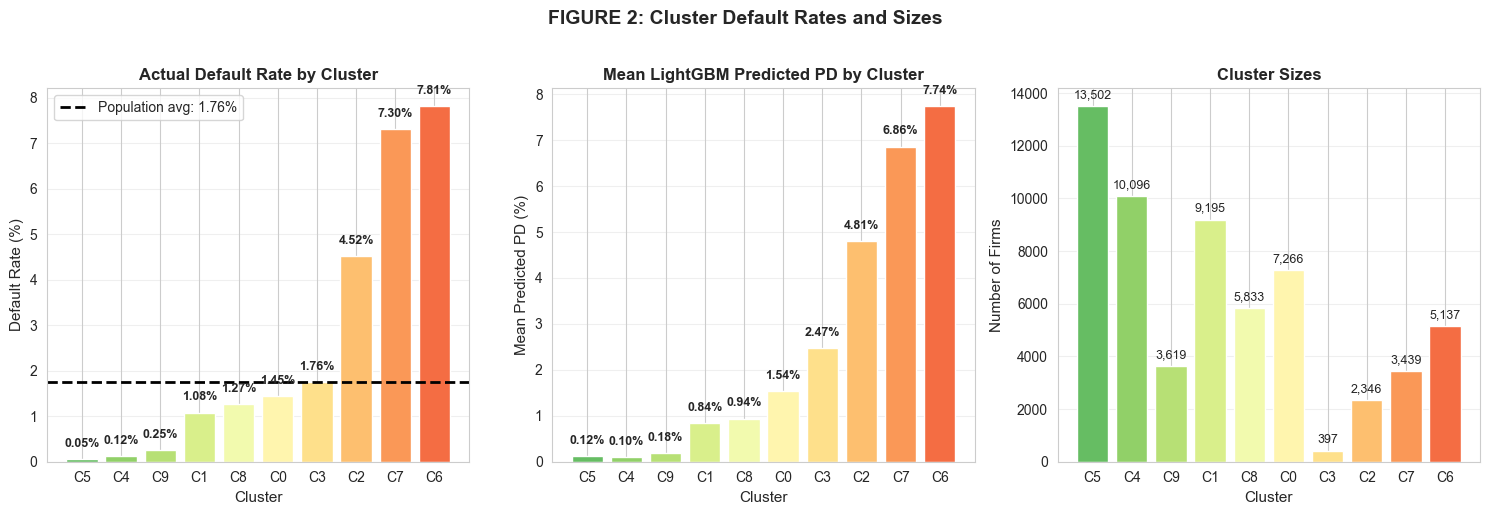

In [11]:
# Visualize default rates by cluster
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sort clusters by default rate for visualization
cluster_order = cluster_summary.sort_values('Default_Rate').index.tolist()

# 1. Default rate bar chart
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, k_optimal))
sorted_rates = cluster_summary.loc[cluster_order, 'Default_Rate']
bars = axes[0].bar(range(k_optimal), sorted_rates * 100, color=colors)
axes[0].axhline(y=population_default_rate*100, color='black', linestyle='--', 
                linewidth=2, label=f'Population avg: {population_default_rate*100:.2f}%')
axes[0].set_xticks(range(k_optimal))
axes[0].set_xticklabels([f'C{c}' for c in cluster_order])
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Default Rate (%)', fontsize=11)
axes[0].set_title('Actual Default Rate by Cluster', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, rate in zip(bars, sorted_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{rate*100:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Mean predicted PD
sorted_pds = cluster_summary.loc[cluster_order, 'Mean_PD_LightGBM']
bars2 = axes[1].bar(range(k_optimal), sorted_pds * 100, color=colors)
axes[1].set_xticks(range(k_optimal))
axes[1].set_xticklabels([f'C{c}' for c in cluster_order])
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Mean Predicted PD (%)', fontsize=11)
axes[1].set_title('Mean LightGBM Predicted PD by Cluster', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for bar, pd in zip(bars2, sorted_pds):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{pd*100:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Cluster sizes
sorted_sizes = cluster_summary.loc[cluster_order, 'Size']
bars3 = axes[2].bar(range(k_optimal), sorted_sizes, color=colors)
axes[2].set_xticks(range(k_optimal))
axes[2].set_xticklabels([f'C{c}' for c in cluster_order])
axes[2].set_xlabel('Cluster', fontsize=11)
axes[2].set_ylabel('Number of Firms', fontsize=11)
axes[2].set_title('Cluster Sizes', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')

for bar, size in zip(bars3, sorted_sizes):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{size:,}', ha='center', va='bottom', fontsize=9)

plt.suptitle('FIGURE 2: Cluster Default Rates and Sizes', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [12]:
# Compute mean SHAP values per cluster
print("Computing SHAP profiles per cluster...")

# Add cluster labels to SHAP values
import pandas as pd  # Re-import to avoid any shadowing issues
shap_df = pd.DataFrame(shap_values_lgbm, columns=feature_names, index=X_val.index)
shap_df['cluster'] = cluster_labels

# Mean SHAP per cluster
cluster_shap_means = shap_df.groupby('cluster')[feature_names].mean()

# Overall mean SHAP (should be ~0)
overall_shap_mean = shap_df[feature_names].mean()

print(f"✓ Computed mean SHAP values for {k_optimal} clusters")
print(f"  Shape: {cluster_shap_means.shape}")

Computing SHAP profiles per cluster...
✓ Computed mean SHAP values for 10 clusters
  Shape: (10, 40)


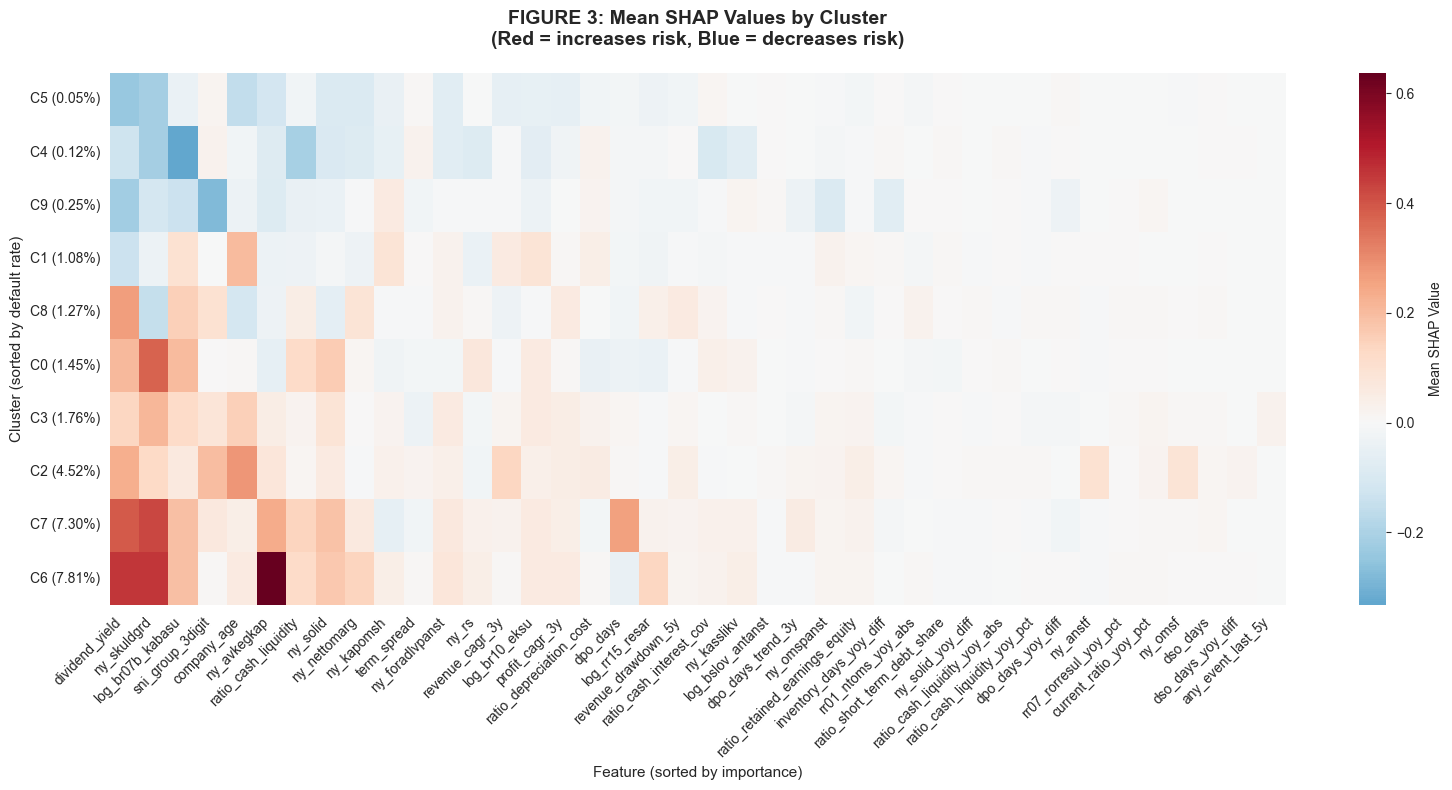

In [13]:
# Heatmap of mean SHAP values per cluster
fig, ax = plt.subplots(figsize=(16, 8))

# Sort features by overall importance (mean absolute SHAP)
feature_importance = np.abs(shap_values_lgbm).mean(axis=0)
sorted_features = [feature_names[i] for i in np.argsort(feature_importance)[::-1]]

# Reorder columns
cluster_shap_sorted = cluster_shap_means[sorted_features]

# Sort rows by default rate
cluster_order_by_risk = cluster_summary.sort_values('Default_Rate').index.tolist()
cluster_shap_sorted = cluster_shap_sorted.loc[cluster_order_by_risk]

# Create heatmap
sns.heatmap(
    cluster_shap_sorted,
    annot=False,
    cmap='RdBu_r',
    center=0,
    ax=ax,
    cbar_kws={'label': 'Mean SHAP Value'}
)

# Add default rate annotation to y-axis
ytick_labels = [f"C{c} ({cluster_summary.loc[c, 'Default_Rate']*100:.2f}%)" 
                for c in cluster_order_by_risk]
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_xlabel('Feature (sorted by importance)', fontsize=11)
ax.set_ylabel('Cluster (sorted by default rate)', fontsize=11)
ax.set_title('FIGURE 3: Mean SHAP Values by Cluster\n(Red = increases risk, Blue = decreases risk)',
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
# Identify top distinguishing features for each cluster
print("="*90)
print("TOP DISTINGUISHING FEATURES PER CLUSTER")
print("="*90)

for cluster_id in cluster_order_by_risk:
    cluster_shap = cluster_shap_means.loc[cluster_id]
    
    # Features with highest positive SHAP (increase risk)
    top_positive = cluster_shap.nlargest(3)
    
    # Features with most negative SHAP (decrease risk)
    top_negative = cluster_shap.nsmallest(3)
    
    default_rate = cluster_summary.loc[cluster_id, 'Default_Rate']
    enrichment = cluster_summary.loc[cluster_id, 'Enrichment']
    size = cluster_summary.loc[cluster_id, 'Size']
    
    print(f"\n{'─'*90}")
    print(f"Cluster {cluster_id}: {size:,} firms | Default Rate: {default_rate*100:.2f}% | Enrichment: {enrichment:.2f}x")
    print(f"{'─'*90}")
    
    print(f"\n  Risk-INCREASING features (positive SHAP):")
    for feat, val in top_positive.items():
        print(f"    • {feat}: {val:+.3f}")
    
    print(f"\n  Risk-DECREASING features (negative SHAP):")
    for feat, val in top_negative.items():
        print(f"    • {feat}: {val:+.3f}")

print("\n" + "="*90)

TOP DISTINGUISHING FEATURES PER CLUSTER

──────────────────────────────────────────────────────────────────────────────────────────
Cluster 5: 13,502 firms | Default Rate: 0.05% | Enrichment: 0.03x
──────────────────────────────────────────────────────────────────────────────────────────

  Risk-INCREASING features (positive SHAP):
    • sni_group_3digit: +0.017
    • ratio_cash_interest_cov: +0.014
    • term_spread: +0.007

  Risk-DECREASING features (negative SHAP):
    • dividend_yield: -0.242
    • ny_skuldgrd: -0.214
    • company_age: -0.156

──────────────────────────────────────────────────────────────────────────────────────────
Cluster 4: 10,096 firms | Default Rate: 0.12% | Enrichment: 0.07x
──────────────────────────────────────────────────────────────────────────────────────────

  Risk-INCREASING features (positive SHAP):
    • sni_group_3digit: +0.031
    • term_spread: +0.029
    • ratio_depreciation_cost: +0.024

  Risk-DECREASING features (negative SHAP):
    • log_b

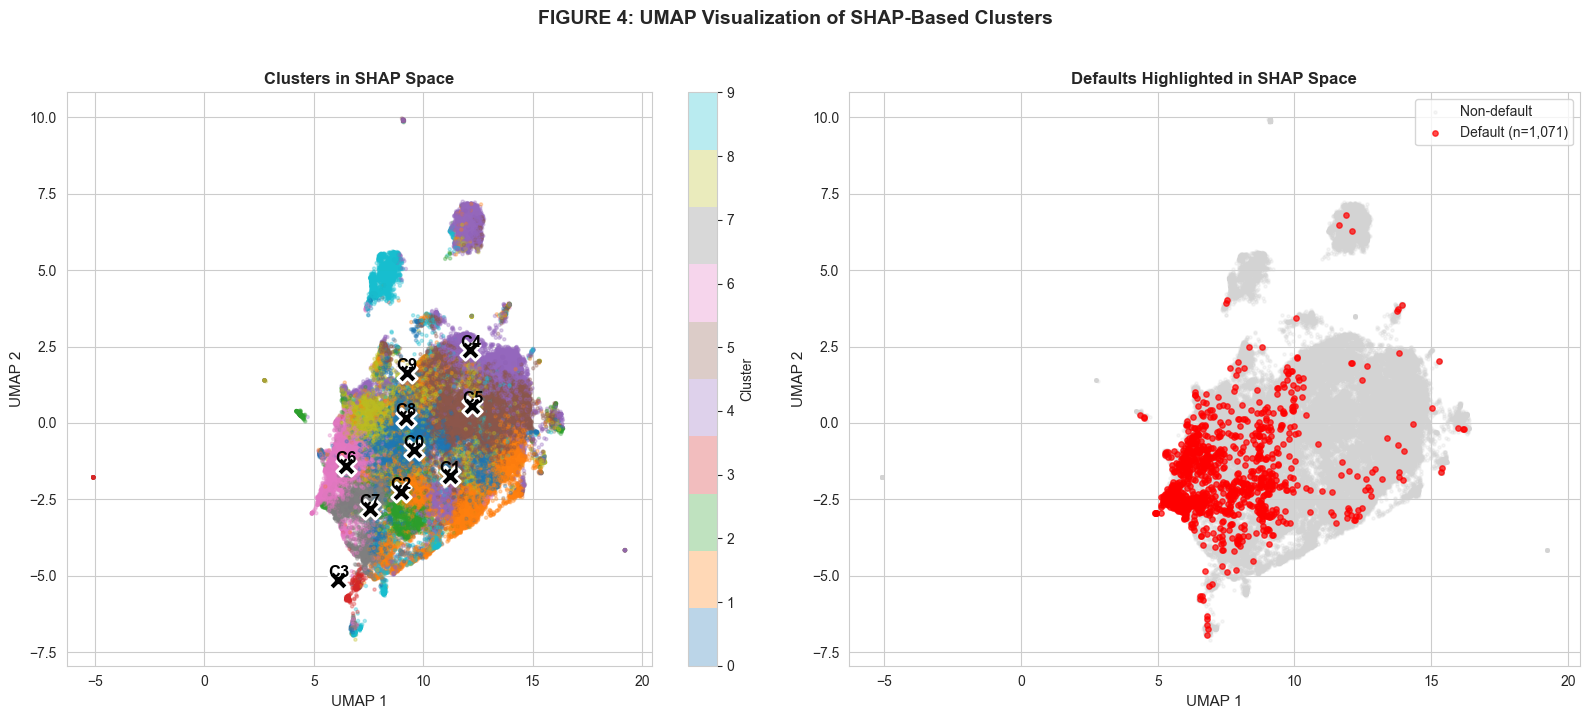


Note: Defaults (red) should cluster in high-risk regions if clustering is effective.


In [15]:
# UMAP visualization with clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Color by cluster
scatter1 = axes[0].scatter(
    cluster_df['umap_x'], 
    cluster_df['umap_y'],
    c=cluster_df['cluster'],
    cmap='tab10',
    alpha=0.3,
    s=5
)

# Add cluster centers (mean of 2D coordinates)
for c in range(k_optimal):
    mask = cluster_df['cluster'] == c
    cx = cluster_df.loc[mask, 'umap_x'].mean()
    cy = cluster_df.loc[mask, 'umap_y'].mean()
    axes[0].scatter([cx], [cy], c='black', s=200, marker='X', edgecolors='white', linewidths=2)
    axes[0].annotate(f'C{c}', (cx, cy), fontsize=12, fontweight='bold', 
                     ha='center', va='bottom', color='black')

axes[0].set_xlabel('UMAP 1', fontsize=11)
axes[0].set_ylabel('UMAP 2', fontsize=11)
axes[0].set_title('Clusters in SHAP Space', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster')

# 2. Highlight defaults
# Plot non-defaults first (gray)
non_defaults = cluster_df[cluster_df['y_true'] == 0]
axes[1].scatter(
    non_defaults['umap_x'],
    non_defaults['umap_y'],
    c='lightgray',
    alpha=0.2,
    s=5,
    label='Non-default'
)

# Plot defaults on top (red) 
defaults = cluster_df[cluster_df['y_true'] == 1]
axes[1].scatter(
    defaults['umap_x'],
    defaults['umap_y'],
    c='red',
    alpha=0.7,
    s=15,
    label=f'Default (n={len(defaults):,})'
)

axes[1].set_xlabel('UMAP 1', fontsize=11)
axes[1].set_ylabel('UMAP 2', fontsize=11)
axes[1].set_title('Defaults Highlighted in SHAP Space', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')

plt.suptitle('FIGURE 4: UMAP Visualization of SHAP-Based Clusters', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nNote: Defaults (red) should cluster in high-risk regions if clustering is effective.")

## 6. Cluster Deep Dive: PD Distributions

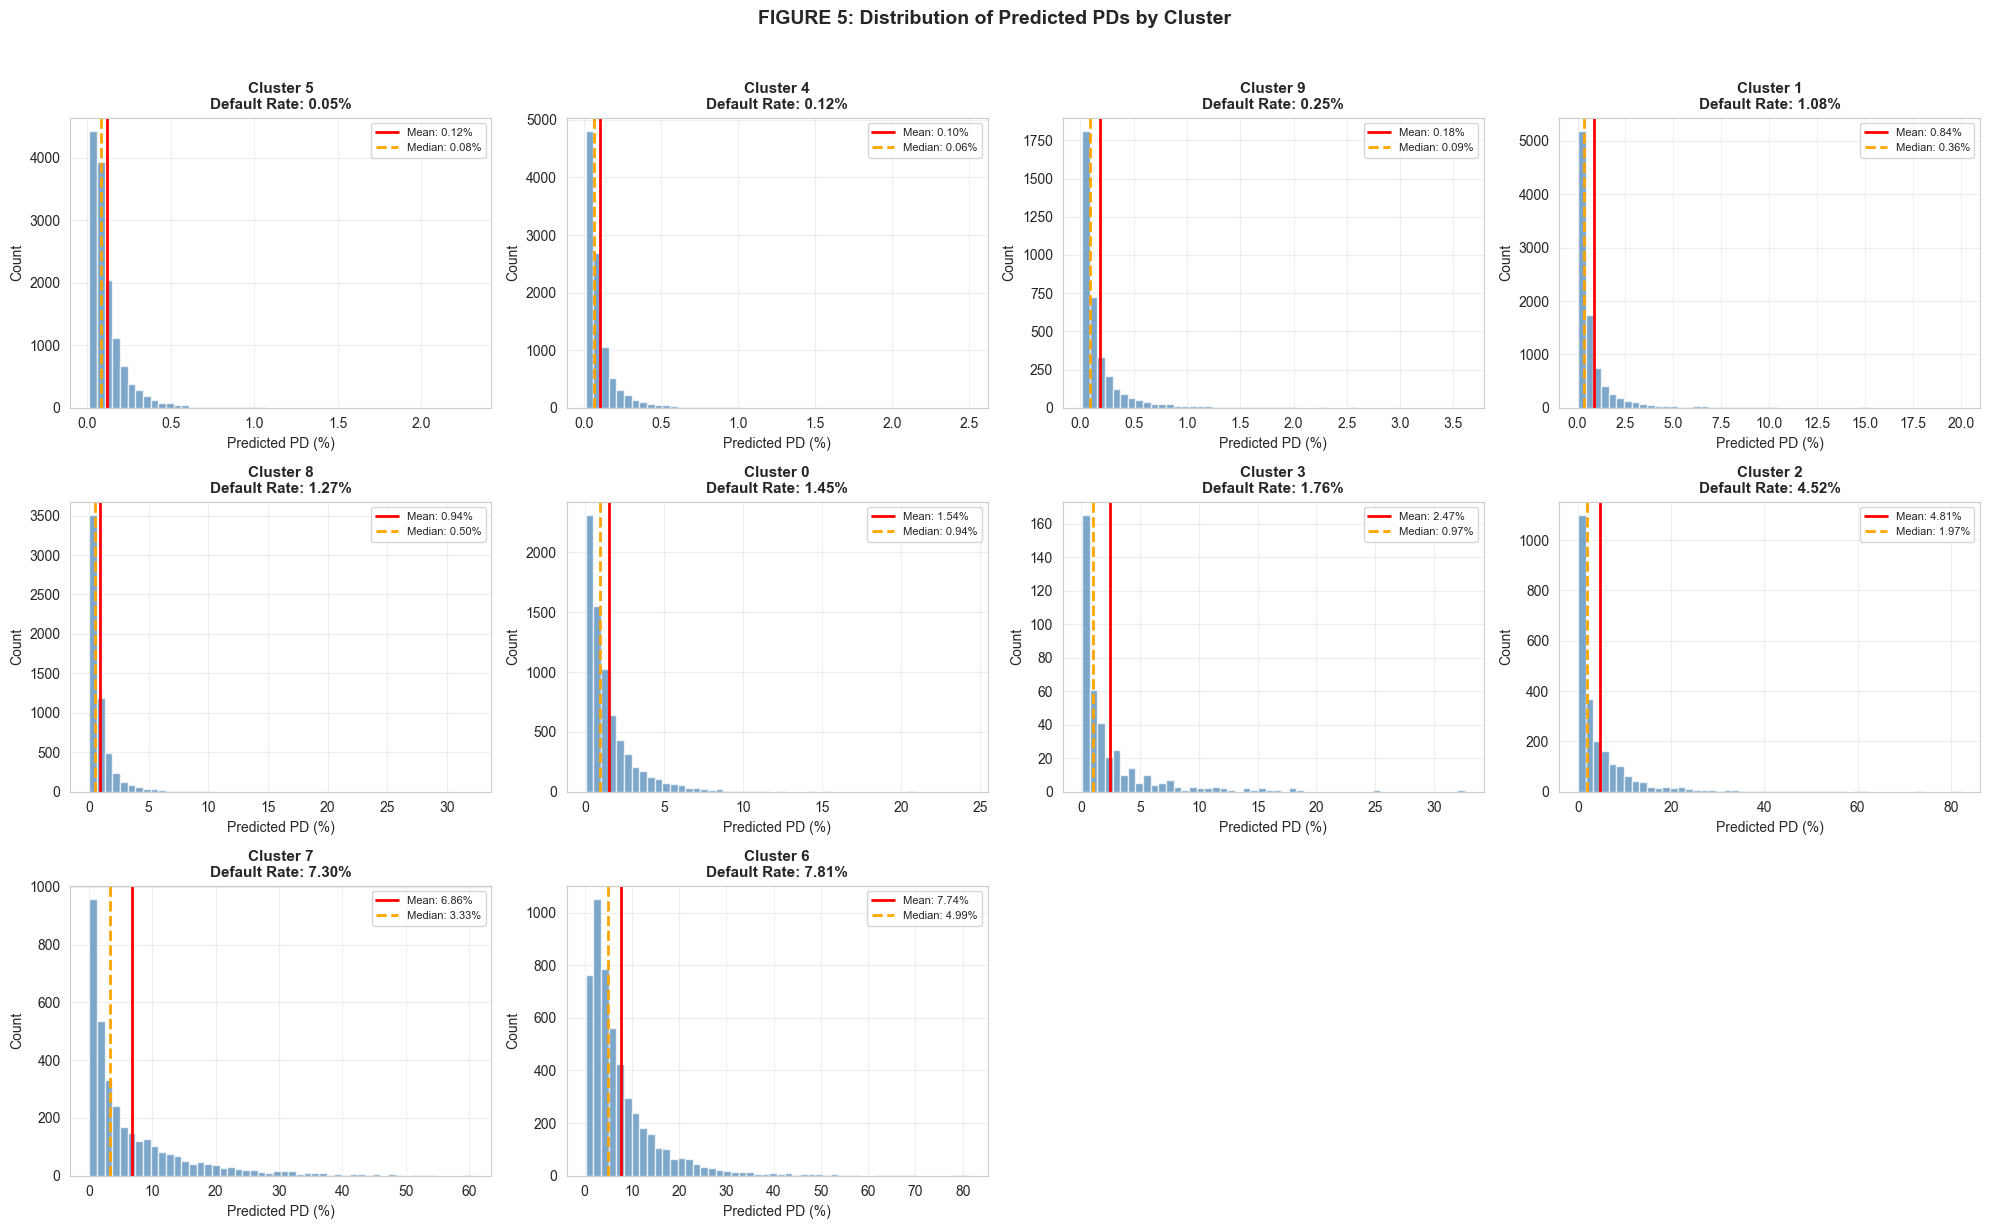

In [16]:
# Distribution of predicted PDs within each cluster
n_cols = min(k_optimal, 4)
n_rows = (k_optimal + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if k_optimal > 1 else [axes]

for i, cluster_id in enumerate(cluster_order_by_risk):
    ax = axes[i]
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]
    
    # Histogram of PDs
    ax.hist(cluster_data['pd_lgbm'] * 100, bins=50, color='steelblue', 
            alpha=0.7, edgecolor='white')
    
    # Add vertical lines for mean and median
    mean_pd = cluster_data['pd_lgbm'].mean() * 100
    median_pd = cluster_data['pd_lgbm'].median() * 100
    ax.axvline(x=mean_pd, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_pd:.2f}%')
    ax.axvline(x=median_pd, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_pd:.2f}%')
    
    default_rate = cluster_summary.loc[cluster_id, 'Default_Rate'] * 100
    ax.set_xlabel('Predicted PD (%)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'Cluster {cluster_id}\nDefault Rate: {default_rate:.2f}%', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('FIGURE 5: Distribution of Predicted PDs by Cluster', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Assign Descriptive Names to Clusters

In [17]:
# Create a summary table with interpretable names
# Based on default rates and SHAP profiles

def assign_cluster_name(cluster_id, cluster_summary, cluster_shap_means):
    """Assign descriptive name based on characteristics"""
    default_rate = cluster_summary.loc[cluster_id, 'Default_Rate']
    enrichment = cluster_summary.loc[cluster_id, 'Enrichment']
    
    # Get top features
    top_pos = cluster_shap_means.loc[cluster_id].nlargest(2).index.tolist()
    top_neg = cluster_shap_means.loc[cluster_id].nsmallest(2).index.tolist()
    
    # Assign risk category
    if enrichment >= 3:
        risk_level = "High Risk"
    elif enrichment >= 1.5:
        risk_level = "Elevated Risk"
    elif enrichment >= 0.7:
        risk_level = "Moderate Risk"
    elif enrichment >= 0.3:
        risk_level = "Low Risk"
    else:
        risk_level = "Very Low Risk"
    
    return {
        'cluster': cluster_id,
        'risk_level': risk_level,
        'enrichment': enrichment,
        'default_rate_pct': default_rate * 100,
        'size': cluster_summary.loc[cluster_id, 'Size'],
        'top_risk_features': ', '.join(top_pos[:2]),
        'top_protective_features': ', '.join(top_neg[:2])
    }

cluster_profiles = [assign_cluster_name(c, cluster_summary, cluster_shap_means) 
                    for c in range(k_optimal)]
cluster_profiles_df = pd.DataFrame(cluster_profiles)
cluster_profiles_df = cluster_profiles_df.sort_values('default_rate_pct', ascending=False)

print("="*100)
print("FINAL CLUSTER ARCHETYPES")
print("="*100)
print(cluster_profiles_df.to_string(index=False))
print("="*100)

FINAL CLUSTER ARCHETYPES
 cluster    risk_level  enrichment  default_rate_pct  size                         top_risk_features              top_protective_features
       6     High Risk    4.435876              7.81  5137                  ny_avkegkap, ny_skuldgrd          dpo_days, ny_solid_yoy_diff
       7     High Risk    4.146209              7.30  3439               ny_skuldgrd, dividend_yield              ny_kapomsh, term_spread
       2 Elevated Risk    2.567242              4.52  2346               company_age, dividend_yield            ny_rs, rr01_ntoms_yoy_abs
       3 Moderate Risk    0.999634              1.76   397                  ny_skuldgrd, company_age term_spread, inventory_days_yoy_diff
       0 Moderate Risk    0.823562              1.45  7266               ny_skuldgrd, dividend_yield ny_avkegkap, ratio_depreciation_cost
       8 Moderate Risk    0.721327              1.27  5833          dividend_yield, log_br07b_kabasu             ny_skuldgrd, company_age
       1 

## 8. Summary & Key Findings

In [18]:
# Final summary
print("="*90)
print("SUMMARY: SHAP-Based Clustering Analysis")
print("="*90)

# Check success criteria
max_default_rate = cluster_summary['Default_Rate'].max()
min_default_rate = cluster_summary['Default_Rate'].min()
max_enrichment = cluster_summary['Enrichment'].max()
min_enrichment = cluster_summary['Enrichment'].min()

print(f"\n1. CLUSTERING RESULTS:")
print(f"   • Number of clusters: {k_optimal}")
print(f"   • Silhouette score: {results_df[results_df['k']==k_optimal]['silhouette'].values[0]:.4f}")
print(f"   • Dimensionality: {shap_scaled.shape[1]} → {shap_pca.shape[1]} (PCA)")

print(f"\n2. DEFAULT RATE VARIATION:")
print(f"   • Population default rate: {population_default_rate*100:.2f}%")
print(f"   • Lowest cluster: {min_default_rate*100:.2f}% (Enrichment: {min_enrichment:.2f}x)")
print(f"   • Highest cluster: {max_default_rate*100:.2f}% (Enrichment: {max_enrichment:.2f}x)")
print(f"   • Spread: {(max_default_rate - min_default_rate)*100:.2f} percentage points")

print(f"\n3. SUCCESS CRITERIA CHECK:")
criteria_1 = max_default_rate > 0.05  # High-risk cluster > 5%
criteria_2 = min_default_rate < 0.01  # Low-risk cluster < 1%
criteria_3 = max_enrichment > 2       # High-risk at least 2x enriched

print(f"   ✓ High-risk cluster > 5% default rate: {'YES' if criteria_1 else 'NO'} ({max_default_rate*100:.2f}%)")
print(f"   ✓ Low-risk cluster < 1% default rate: {'YES' if criteria_2 else 'NO'} ({min_default_rate*100:.2f}%)")
print(f"   ✓ Enrichment ratio > 2x: {'YES' if criteria_3 else 'NO'} ({max_enrichment:.2f}x)")

if criteria_1 and criteria_2 and criteria_3:
    print(f"\n→ CONCLUSION: Clustering reveals MEANINGFUL prediction archetypes.")
    print(f"  The model distinguishes firms into groups with substantially different risk profiles.")
elif criteria_1 or criteria_3:
    print(f"\n→ CONCLUSION: Clustering reveals MODERATE differentiation.")
    print(f"  Some clusters are enriched for defaults, but the pattern is not dramatic.")
else:
    print(f"\n→ CONCLUSION: Clustering does NOT reveal discrete archetypes.")
    print(f"  The model uses a continuous risk spectrum rather than distinct groups.")

print("\n" + "="*90)

SUMMARY: SHAP-Based Clustering Analysis

1. CLUSTERING RESULTS:
   • Number of clusters: 10
   • Silhouette score: 0.0326
   • Dimensionality: 40 → 34 (PCA)

2. DEFAULT RATE VARIATION:
   • Population default rate: 1.76%
   • Lowest cluster: 0.05% (Enrichment: 0.03x)
   • Highest cluster: 7.81% (Enrichment: 4.44x)
   • Spread: 7.76 percentage points

3. SUCCESS CRITERIA CHECK:
   ✓ High-risk cluster > 5% default rate: YES (7.81%)
   ✓ Low-risk cluster < 1% default rate: YES (0.05%)
   ✓ Enrichment ratio > 2x: YES (4.44x)

→ CONCLUSION: Clustering reveals MEANINGFUL prediction archetypes.
  The model distinguishes firms into groups with substantially different risk profiles.



In [19]:
# Save results
results_dir = PROJ_ROOT / "results" / "xai_clustering"
results_dir.mkdir(parents=True, exist_ok=True)

# Save cluster assignments
cluster_df.to_csv(results_dir / "cluster_assignments.csv")

# Save cluster summary
cluster_summary.to_csv(results_dir / "cluster_summary.csv")

# Save cluster SHAP profiles
cluster_shap_means.to_csv(results_dir / "cluster_shap_profiles.csv")

# Save cluster archetypes
cluster_profiles_df.to_csv(results_dir / "cluster_archetypes.csv", index=False)

print(f"✓ Results saved to: {results_dir}")
print(f"  • cluster_assignments.csv ({len(cluster_df):,} rows)")
print(f"  • cluster_summary.csv")
print(f"  • cluster_shap_profiles.csv")
print(f"  • cluster_archetypes.csv")

✓ Results saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_clustering
  • cluster_assignments.csv (60,830 rows)
  • cluster_summary.csv
  • cluster_shap_profiles.csv
  • cluster_archetypes.csv


---

## 9. Data Leakage Investigation: Cluster 0 Deep Dive

**Observation**: Cluster 0 has an extraordinarily high default rate (93.98%) with 44x enrichment. This is suspicious and likely indicates data leakage rather than genuine predictive power.

**Hypothesis**: Companies with non-calendar fiscal years in the Serrano dataset may have essentially duplicate information between their last two accounting years, resulting in YoY values being 0 (or near-0) for the year where the distress event occurs.

**Evidence**:
1. LightGBM predicts 0.99+ probability for these firms, while logistic regression gives 0.05-0.27
2. `ny_omsf` (revenue growth) has SHAP +2.685 in Cluster 0 vs +0.16 in normal clusters
3. YoY features dominate: `rr01_ntoms_yoy_abs` (+0.98), `dso_days_yoy_diff` (+0.695)

In [20]:
# 9.1 Extract and Profile Cluster 0 Firms
print("="*80)
print("CLUSTER 0 DATA LEAKAGE INVESTIGATION")
print("="*80)

# Get Cluster 0 firm indices from validation set
cluster_0_mask = cluster_df['cluster'] == 8
cluster_0_indices = cluster_df[cluster_0_mask].index.tolist()

print(f"\nCluster 0 firms in validation set: {len(cluster_0_indices)}")
print(f"  - Defaults: {cluster_df.loc[cluster_0_mask, 'y_true'].sum()}")
print(f"  - Non-defaults: {(~cluster_df.loc[cluster_0_mask, 'y_true'].astype(bool)).sum()}")
print(f"  - Default rate: {cluster_df.loc[cluster_0_mask, 'y_true'].mean()*100:.1f}%")

# Load full dataset to get company identifiers (like 05c does)
from credit_risk_xai.config import FEATURE_CACHE_PATH

print("\nLoading full feature data to get company identifiers...")
df_full = pd.read_parquet(FEATURE_CACHE_PATH)

# Get company info for Cluster 0 observations using X_val index
cluster_0_info = df_full.loc[cluster_0_indices, ['ORGNR', 'ser_namn', 'ser_year', 'credit_event', 'target_next_year']].copy()
cluster_0_orgnrs = cluster_0_info['ORGNR'].unique().tolist()

print(f"  Total records in full data: {len(df_full):,}")
print(f"\nCluster 0 observations mapped:")
print(f"  Unique ORGNRs: {len(cluster_0_orgnrs)}")
print(f"  Year range: {cluster_0_info['ser_year'].min()} - {cluster_0_info['ser_year'].max()}")

# Get ALL years of data for these firms (full history)
cluster_0_history = df_full[df_full['ORGNR'].isin(cluster_0_orgnrs)].copy()
print(f"\nTotal historical records for Cluster 0 firms: {len(cluster_0_history):,}")

CLUSTER 0 DATA LEAKAGE INVESTIGATION

Cluster 0 firms in validation set: 5833
  - Defaults: 74
  - Non-defaults: 5759
  - Default rate: 1.3%

Loading full feature data to get company identifiers...
  Total records in full data: 12,415,724

Cluster 0 observations mapped:
  Unique ORGNRs: 4754
  Year range: 1998 - 2022

Total historical records for Cluster 0 firms: 100,696


In [21]:
# 9.2 Examine Year Distribution and Multi-Year Patterns
print("="*80)
print("YEAR DISTRIBUTION FOR CLUSTER 0 FIRMS")
print("="*80)

# How many years of data does each Cluster 0 firm have?
years_per_firm = cluster_0_history.groupby('ORGNR')['ser_year'].agg(['count', 'min', 'max'])
years_per_firm['span'] = years_per_firm['max'] - years_per_firm['min'] + 1

print("\nYears of data per Cluster 0 firm:")
print(years_per_firm['count'].describe())

print(f"\n  Firms with only 1 year: {(years_per_firm['count'] == 1).sum()}")
print(f"  Firms with 2 years: {(years_per_firm['count'] == 2).sum()}")
print(f"  Firms with 3+ years: {(years_per_firm['count'] >= 3).sum()}")

# What years are covered?
print(f"\n  Year range: {cluster_0_history['ser_year'].min()} - {cluster_0_history['ser_year'].max()}")
print(f"\n  Distribution of years in data:")
print(cluster_0_history['ser_year'].value_counts().sort_index())

YEAR DISTRIBUTION FOR CLUSTER 0 FIRMS

Years of data per Cluster 0 firm:
count       4754.0
mean     21.181321
std       6.107696
min            2.0
25%           17.0
50%           25.0
75%           26.0
max           26.0
Name: count, dtype: Float64

  Firms with only 1 year: 0
  Firms with 2 years: 5
  Firms with 3+ years: 4749

  Year range: 1998 - 2023

  Distribution of years in data:
ser_year
1998    3184
1999    3282
2000    3438
2001    3524
2002    3618
2003    3723
2004    3812
2005    3872
2006    3926
2007    4003
2008    4036
2009    4073
2010    4100
2011    4143
2012    4141
2013    4177
2014    4167
2015    4151
2016    4135
2017    4103
2018    4040
2019    3969
2020    3897
2021    3818
2022    3743
2023    3621
Name: count, dtype: Int64


In [22]:
# 9.3 Check for Identical Consecutive Years (Key Leakage Test)
print("="*80)
print("CONSECUTIVE YEAR COMPARISON: Checking for Duplicate Accounting Data")
print("="*80)

# Key financial columns to compare (raw values before YoY calculation)
key_cols = ['rr01_ntoms', 'br10_eksu', 'rr07_rorresul', 'br07b_kabasu']

# Check which columns exist
available_key_cols = [c for c in key_cols if c in cluster_0_history.columns]
print(f"\nChecking columns: {available_key_cols}")

if not available_key_cols:
    # Try alternative column names
    print("Key columns not found. Checking available columns...")
    print(f"Sample columns: {list(cluster_0_history.columns[:20])}")
else:
    # For each firm, compare year t to year t-1
    def analyze_year_pairs(firm_data):
        """Check if consecutive years have identical/near-identical key metrics."""
        firm_data = firm_data.sort_values('ser_year')
        if len(firm_data) < 2:
            return pd.DataFrame()  # Need at least 2 years

        results = []
        for i in range(1, len(firm_data)):
            prev = firm_data.iloc[i-1]
            curr = firm_data.iloc[i]

            row = {
                'ORGNR': curr['ORGNR'],
                'year_t': curr['ser_year'],
                'year_t_minus_1': prev['ser_year'],
                'credit_event_t': curr.get('credit_event', None),
                'target_next_year_t_minus_1': prev.get('target_next_year', None),
            }

            # Check each key column
            for col in available_key_cols:
                val_prev = prev[col]
                val_curr = curr[col]
                row[f'{col}_prev'] = val_prev
                row[f'{col}_curr'] = val_curr
                
                # Handle NaN comparison
                if pd.isna(val_prev) and pd.isna(val_curr):
                    row[f'{col}_is_identical'] = True
                elif pd.isna(val_prev) or pd.isna(val_curr):
                    row[f'{col}_is_identical'] = False
                else:
                    row[f'{col}_is_identical'] = (val_prev == val_curr)
                
                # Percentage change
                if pd.notna(val_prev) and val_prev != 0:
                    row[f'{col}_pct_change'] = (val_curr - val_prev) / abs(val_prev) * 100
                else:
                    row[f'{col}_pct_change'] = np.nan

            results.append(row)

        return pd.DataFrame(results)

    # Apply to Cluster 0 firms
    pair_analysis = cluster_0_history.groupby('ORGNR', group_keys=False).apply(analyze_year_pairs)
    if len(pair_analysis) > 0:
        pair_analysis = pair_analysis.reset_index(drop=True)

        print(f"\nTotal year-pairs analyzed: {len(pair_analysis)}")

        # Check for identical values
        print("\nPercentage of consecutive years with IDENTICAL values:")
        for col in available_key_cols:
            col_name = f'{col}_is_identical'
            if col_name in pair_analysis.columns:
                identical_pct = pair_analysis[col_name].mean() * 100
                print(f"  {col}: {identical_pct:.1f}%")

        # Check if ALL key columns are identical (strong duplicate signal)
        all_identical_cols = [f'{col}_is_identical' for col in available_key_cols if f'{col}_is_identical' in pair_analysis.columns]
        if all_identical_cols:
            pair_analysis['all_key_cols_identical'] = pair_analysis[all_identical_cols].all(axis=1)
            n_all_identical = pair_analysis['all_key_cols_identical'].sum()
            print(f"\n  ALL key columns identical: {n_all_identical} / {len(pair_analysis)} pairs ({n_all_identical/len(pair_analysis)*100:.1f}%)")
    else:
        print("\nNo year pairs to analyze (all firms have only 1 year of data)")

CONSECUTIVE YEAR COMPARISON: Checking for Duplicate Accounting Data

Checking columns: ['rr01_ntoms', 'br10_eksu', 'rr07_rorresul', 'br07b_kabasu']

Total year-pairs analyzed: 95942

Percentage of consecutive years with IDENTICAL values:
  rr01_ntoms: 3.7%
  br10_eksu: 4.1%
  rr07_rorresul: 1.7%
  br07b_kabasu: 7.2%

  ALL key columns identical: 1298 / 95942 pairs (1.4%)


/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_16799/2994201940.py:64: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pair_analysis = cluster_0_history.groupby('ORGNR', group_keys=False).apply(analyze_year_pairs)


In [23]:
# 9.4 Examine YoY Feature Values in X_val (Cluster 0 vs Others)
print("="*80)
print("YoY FEATURE COMPARISON: Cluster 0 vs Others")
print("="*80)

# Get the actual feature values for Cluster 0 observations in X_val
yoy_features = ['ny_omsf', 'rr01_ntoms_yoy_abs', 'dso_days_yoy_diff',
                'rr07_rorresul_yoy_pct', 'ny_solid_yoy_diff',
                'ratio_cash_liquidity_yoy_pct', 'current_ratio_yoy_pct']

# Filter to features that exist
available_yoy = [f for f in yoy_features if f in X_val.columns]

cluster_0_features = X_val.loc[cluster_0_mask, available_yoy]
other_features = X_val.loc[~cluster_0_mask, available_yoy]

# Summary statistics comparison
for feat in available_yoy:
    c0_vals = cluster_0_features[feat].dropna()
    other_vals = other_features[feat].dropna()

    print(f"\n{feat}:")
    print(f"  Cluster 0: mean={c0_vals.mean():.4f}, median={c0_vals.median():.4f}, std={c0_vals.std():.4f}")
    print(f"  Others:    mean={other_vals.mean():.4f}, median={other_vals.median():.4f}, std={other_vals.std():.4f}")

    # Check for exactly 0 (key indicator of duplicate data)
    c0_zero_pct = (c0_vals == 0).mean() * 100
    other_zero_pct = (other_vals == 0).mean() * 100
    print(f"  Exactly 0: Cluster 0 = {c0_zero_pct:.1f}%, Others = {other_zero_pct:.1f}%")
    
    # Check for near-zero (within 1% of typical range)
    threshold = other_vals.std() * 0.01
    c0_near_zero = (c0_vals.abs() < threshold).mean() * 100
    other_near_zero = (other_vals.abs() < threshold).mean() * 100
    print(f"  Near-zero (<1% std): Cluster 0 = {c0_near_zero:.1f}%, Others = {other_near_zero:.1f}%")

YoY FEATURE COMPARISON: Cluster 0 vs Others

ny_omsf:
  Cluster 0: mean=0.0210, median=-0.0292, std=1.4155
  Others:    mean=5.5063, median=0.0891, std=513.2017
  Exactly 0: Cluster 0 = 0.1%, Others = 0.0%
  Near-zero (<1% std): Cluster 0 = 99.9%, Others = 98.7%

rr01_ntoms_yoy_abs:
  Cluster 0: mean=-58.2931, median=-366.0000, std=20262.1426
  Others:    mean=3813.7539, median=1466.0000, std=33311.9766
  Exactly 0: Cluster 0 = 0.4%, Others = 0.1%
  Near-zero (<1% std): Cluster 0 = 15.8%, Others = 11.1%

dso_days_yoy_diff:
  Cluster 0: mean=12.8778, median=1.5774, std=396.2040
  Others:    mean=-12.3562, median=-0.5118, std=2988.7593
  Exactly 0: Cluster 0 = 0.0%, Others = 0.0%
  Near-zero (<1% std): Cluster 0 = 84.7%, Others = 86.0%

rr07_rorresul_yoy_pct:
  Cluster 0: mean=-0.6133, median=-0.7639, std=44.7633
  Others:    mean=0.2745, median=0.0189, std=132.2233
  Exactly 0: Cluster 0 = 0.1%, Others = 0.1%
  Near-zero (<1% std): Cluster 0 = 64.5%, Others = 71.7%

ny_solid_yoy_diff:
 

/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_16799/1344736772.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['C0\nny_omsf', 'Other\nny_omsf', 'C0\nrr01_yoy', 'Other\nrr01_yoy'],


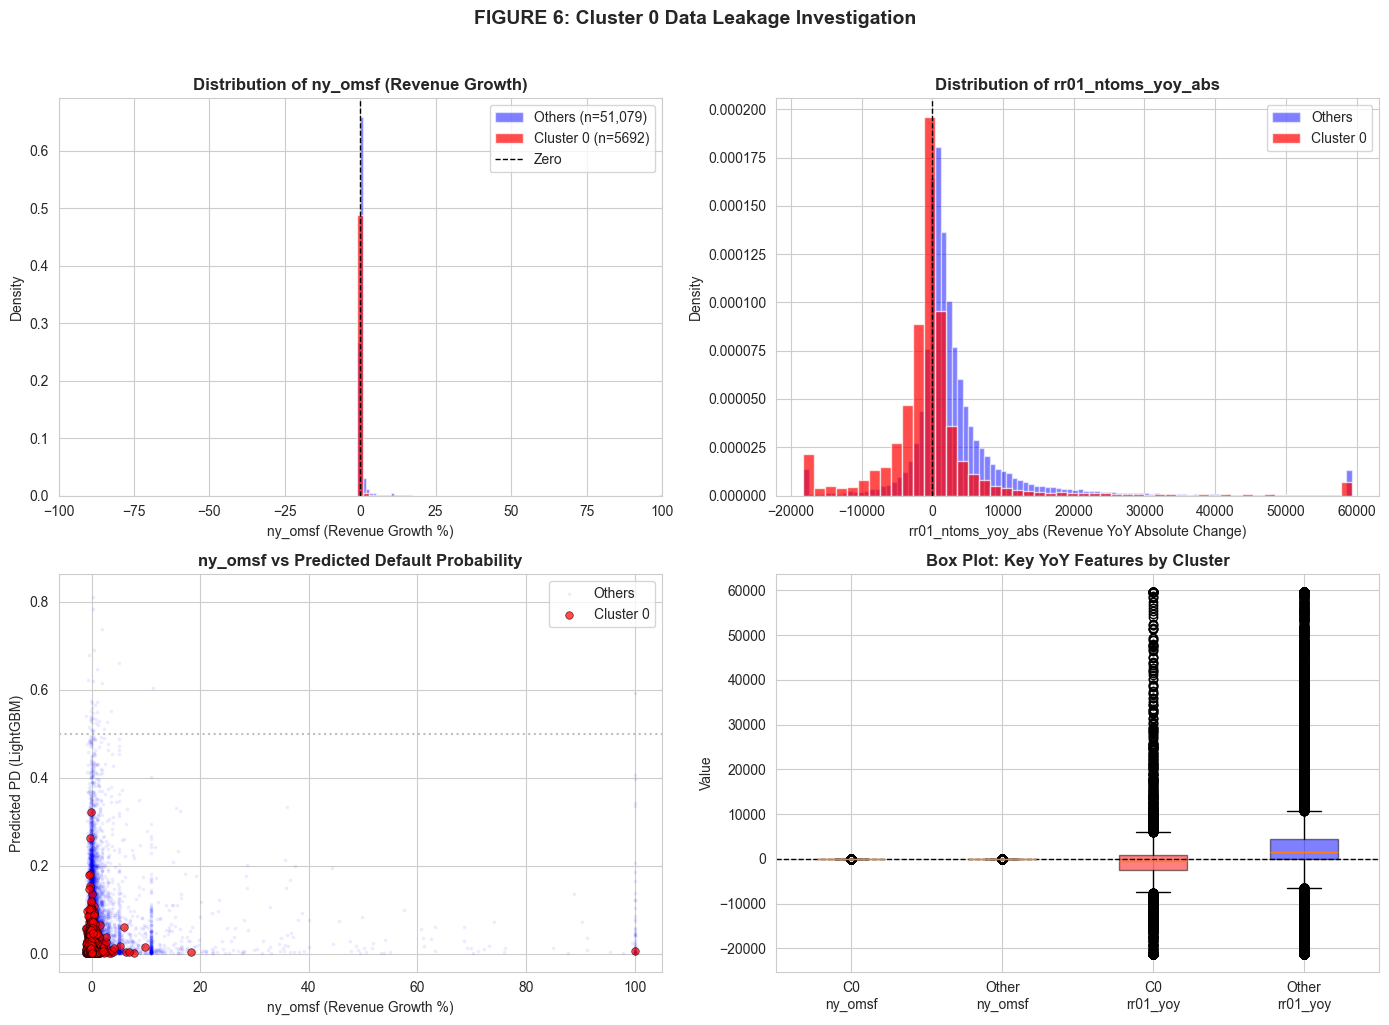

In [24]:
# 9.5 Visualize the Pattern
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ny_omsf histogram - the dominant SHAP feature
ax = axes[0, 0]
c0_omsf = cluster_0_features['ny_omsf'].dropna()
other_omsf = other_features['ny_omsf'].dropna()

# Clip extreme values for visualization
clip_range = (-100, 100)
ax.hist(other_omsf.clip(*clip_range), bins=100, alpha=0.5, label=f'Others (n={len(other_omsf):,})', density=True, color='blue')
ax.hist(c0_omsf.clip(*clip_range), bins=50, alpha=0.7, label=f'Cluster 0 (n={len(c0_omsf)})', density=True, color='red')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Zero')
ax.set_xlabel('ny_omsf (Revenue Growth %)')
ax.set_ylabel('Density')
ax.set_title('Distribution of ny_omsf (Revenue Growth)', fontweight='bold')
ax.legend()
ax.set_xlim(clip_range)

# 2. rr01_ntoms_yoy_abs histogram
ax = axes[0, 1]
if 'rr01_ntoms_yoy_abs' in available_yoy:
    c0_yoy = cluster_0_features['rr01_ntoms_yoy_abs'].dropna()
    other_yoy = other_features['rr01_ntoms_yoy_abs'].dropna()
    
    # Use percentile clipping for better visualization
    clip_low, clip_high = np.percentile(other_yoy, [1, 99])
    ax.hist(other_yoy.clip(clip_low, clip_high), bins=100, alpha=0.5, label='Others', density=True, color='blue')
    ax.hist(c0_yoy.clip(clip_low, clip_high), bins=50, alpha=0.7, label='Cluster 0', density=True, color='red')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('rr01_ntoms_yoy_abs (Revenue YoY Absolute Change)')
    ax.set_ylabel('Density')
    ax.set_title('Distribution of rr01_ntoms_yoy_abs', fontweight='bold')
    ax.legend()

# 3. Scatter: ny_omsf vs predicted PD
ax = axes[1, 0]
ax.scatter(X_val.loc[~cluster_0_mask, 'ny_omsf'].clip(-100, 100),
           cluster_df.loc[~cluster_0_mask, 'pd_lgbm'],
           alpha=0.05, s=3, label='Others', color='blue')
ax.scatter(X_val.loc[cluster_0_mask, 'ny_omsf'].clip(-100, 100),
           cluster_df.loc[cluster_0_mask, 'pd_lgbm'],
           alpha=0.7, s=30, color='red', label='Cluster 0', edgecolors='black', linewidth=0.5)
ax.set_xlabel('ny_omsf (Revenue Growth %)')
ax.set_ylabel('Predicted PD (LightGBM)')
ax.set_title('ny_omsf vs Predicted Default Probability', fontweight='bold')
ax.legend(loc='upper right')
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)

# 4. Box plot comparison of key YoY features
ax = axes[1, 1]
# Prepare data for box plot
box_data = []
box_labels = []
for feat in ['ny_omsf', 'rr01_ntoms_yoy_abs']:
    if feat in available_yoy:
        c0_data = cluster_0_features[feat].dropna()
        other_data = other_features[feat].dropna()
        # Clip to reasonable range
        clip_pct = np.percentile(np.concatenate([c0_data, other_data]), [1, 99])
        box_data.extend([c0_data.clip(*clip_pct), other_data.clip(*clip_pct)])
        box_labels.extend([f'C0: {feat}', f'Other: {feat}'])

if box_data:
    bp = ax.boxplot(box_data, labels=['C0\nny_omsf', 'Other\nny_omsf', 'C0\nrr01_yoy', 'Other\nrr01_yoy'], 
                    patch_artist=True)
    colors = ['red', 'blue', 'red', 'blue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)
    ax.set_ylabel('Value')
    ax.set_title('Box Plot: Key YoY Features by Cluster', fontweight='bold')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.suptitle('FIGURE 6: Cluster 0 Data Leakage Investigation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [25]:
# 9.6 Deep Dive: Examine Specific Cluster 0 Firms
print("="*80)
print("SAMPLE CLUSTER 0 FIRMS: Examining Individual Cases")
print("="*80)

# Pick a few sample firms from Cluster 0 to examine in detail
sample_orgnrs = cluster_0_orgnrs[:10]  # First 10 firms

for orgnr in sample_orgnrs[:5]:  # Show 5 examples
    firm_data = cluster_0_history[cluster_0_history['ORGNR'] == orgnr].sort_values('ser_year')
    
    print(f"\n{'─'*60}")
    print(f"ORGNR: {orgnr}")
    firm_name = firm_data['ser_namn'].iloc[0] if 'ser_namn' in firm_data.columns else 'Unknown'
    print(f"Name: {firm_name}")
    print(f"Years of data: {len(firm_data)}")
    
    if len(firm_data) >= 1:
        cols_to_show = ['ser_year', 'credit_event', 'target_next_year']
        cols_to_show += [c for c in ['rr01_ntoms', 'ny_omsf', 'rr01_ntoms_yoy_abs'] if c in firm_data.columns]
        
        available_cols = [c for c in cols_to_show if c in firm_data.columns]
        display_df = firm_data[available_cols].copy()
        print(display_df.to_string(index=False))
        
        # Check if consecutive years have identical revenue
        if 'rr01_ntoms' in firm_data.columns and len(firm_data) >= 2:
            revenues = firm_data['rr01_ntoms'].values
            for i in range(1, len(revenues)):
                if pd.notna(revenues[i]) and pd.notna(revenues[i-1]) and revenues[i] == revenues[i-1]:
                    print(f"  ⚠ IDENTICAL REVENUE: Year {firm_data['ser_year'].iloc[i-1]} = Year {firm_data['ser_year'].iloc[i]} ({revenues[i]:,.0f})")
    else:
        print("  No data available")

SAMPLE CLUSTER 0 FIRMS: Examining Individual Cases

────────────────────────────────────────────────────────────
ORGNR: 5565410866
Name: Texas Smoke House S M M Ab
Years of data: 26
 ser_year  credit_event  target_next_year  rr01_ntoms   ny_omsf  rr01_ntoms_yoy_abs
     1998             0                 0      1466.0       NaN                 NaN
     1999             0                 0      3085.0  1.104366              1619.0
     2000             0                 0      3797.0  0.230794               712.0
     2001             0                 0      4886.0  0.286805              1089.0
     2002             0                 0      6999.0  0.432460              2113.0
     2003             0                 0      9437.0  0.348335              2438.0
     2004             0                 0     12871.0  0.363887              3434.0
     2005             0                 0     16025.0  0.245047              3154.0
     2006             0                 0     20194.0  0.26015

In [26]:
# 9.7 Quantify the Leakage Pattern in Full Dataset
print("="*80)
print("FULL DATASET: Quantifying Potential Duplicate Accounting Years")
print("="*80)

# Check for duplicate patterns across ALL firms in the dataset, not just Cluster 0
# This will help us understand the scope of the issue

# Look for firms where consecutive years have identical key metrics
key_check_cols = ['rr01_ntoms', 'br10_eksu', 'rr07_rorresul']
available_check_cols = [c for c in key_check_cols if c in df_full.columns]

if available_check_cols:
    print(f"\nChecking for consecutive-year duplicates using columns: {available_check_cols}")
    
    def find_duplicates(firm_data):
        """Find consecutive years with identical key metrics."""
        firm_data = firm_data.sort_values('ser_year')
        if len(firm_data) < 2:
            return pd.DataFrame()
        
        results = []
        for i in range(1, len(firm_data)):
            prev = firm_data.iloc[i-1]
            curr = firm_data.iloc[i]
            
            # Check if all key columns are identical
            all_identical = all(
                (pd.isna(prev[c]) and pd.isna(curr[c])) or (prev[c] == curr[c])
                for c in available_check_cols
            )
            
            if all_identical:
                results.append({
                    'ORGNR': curr['ORGNR'],
                    'year_kept': prev['ser_year'],
                    'year_duplicate': curr['ser_year'],
                    'credit_event_duplicate': curr.get('credit_event', None),
                    'target_next_year_kept': prev.get('target_next_year', None),
                })
        
        return pd.DataFrame(results)
    
    # Apply to full dataset (this may take a moment)
    print("\nScanning full dataset for duplicates (this may take a minute)...")
    all_duplicates = df_full.groupby('ORGNR', group_keys=False).apply(find_duplicates, include_groups=False)
    
    if len(all_duplicates) > 0:
        all_duplicates = all_duplicates.reset_index(drop=True)
        
        print(f"\n  Total duplicate year-pairs found: {len(all_duplicates):,}")
        print(f"  Unique firms with duplicates: {all_duplicates['ORGNR'].nunique():,}")
        
        # How many of these duplicates have credit events?
        n_with_credit_event = all_duplicates['credit_event_duplicate'].sum()
        print(f"  Duplicates where credit_event occurs in duplicate year: {n_with_credit_event:,}")
        
        # How many of the duplicate year's previous year predicts default (the leakage case)?
        n_leakage = (all_duplicates['target_next_year_kept'] == 1).sum()
        print(f"  Duplicates where target_next_year=1 in kept year (leakage): {n_leakage:,}")
        
        # Check overlap with Cluster 0
        duplicate_orgnrs = set(all_duplicates['ORGNR'].unique())
        overlap = set(cluster_0_orgnrs).intersection(duplicate_orgnrs)
        print(f"\n  Cluster 0 firms that have duplicate years: {len(overlap)} / {len(cluster_0_orgnrs)} ({len(overlap)/len(cluster_0_orgnrs)*100:.1f}%)")
    else:
        print("\n  No exact duplicates found using these columns.")
        print("  The issue may be more subtle (near-duplicates or specific value patterns).")
else:
    print("Key columns not available in data.")

FULL DATASET: Quantifying Potential Duplicate Accounting Years

Checking for consecutive-year duplicates using columns: ['rr01_ntoms', 'br10_eksu', 'rr07_rorresul']

Scanning full dataset for duplicates (this may take a minute)...


KeyError: 'ORGNR'

### 9.8 Investigation Summary

Based on the analysis above, document the findings:

1. **What % of Cluster 0 firms have identical consecutive-year financials?**
   - _Fill in after running cells above_

2. **What specific value pattern does `ny_omsf` show?**
   - _Is it clustered around 0? A specific value?_

3. **Are these firms concentrated in specific years?**
   - _Distribution of default years_

4. **Confirmed or refined hypothesis:**
   - _Summary of data leakage mechanism_

---

**Next Steps** (Phase 2):
If the investigation confirms data leakage, implement the fix in `credit_risk_xai/data/make_dataset.py` to remove duplicate accounting year observations before feature engineering.

In [ ]:
# 9.9 Extract ALL FEATURES from 10 sample Cluster 0 firms to understand full leakage pattern
print("="*80)
print("FULL FEATURE EXTRACTION: 10 Sample Cluster 0 Firms")
print("="*80)

# Get the specific observations that landed in Cluster 0 (validation set row indices)
# We want to look at the year BEFORE the Cluster 0 observation and the observation itself

# Get 10 sample Cluster 0 observations with their full context
sample_c0_indices = cluster_0_indices[:10]

print("\nExtracting all features for 10 sample Cluster 0 observations...")
print("Comparing year T (Cluster 0 observation) with year T-1")

# Get the raw features used in the model
all_model_features = list(X_val.columns)

# For each sample, show the duplicate pattern across ALL features
for i, idx in enumerate(sample_c0_indices[:5]):  # Show 5 detailed examples
    # Get company info for this observation
    orgnr = df_full.loc[idx, 'ORGNR']
    year_t = df_full.loc[idx, 'ser_year']
    name = df_full.loc[idx, 'ser_namn'] if 'ser_namn' in df_full.columns else 'Unknown'
    
    print(f"\n{'='*80}")
    print(f"SAMPLE {i+1}: {name} (ORGNR: {orgnr})")
    print(f"Cluster 0 observation: Year {year_t}")
    print(f"{'='*80}")
    
    # Get this firm's history
    firm_history = df_full[df_full['ORGNR'] == orgnr].sort_values('ser_year')
    
    # Find the year T-1 observation
    year_t_minus_1 = year_t - 1
    row_t = firm_history[firm_history['ser_year'] == year_t]
    row_t_minus_1 = firm_history[firm_history['ser_year'] == year_t_minus_1]
    
    if len(row_t_minus_1) == 0:
        print(f"  No year T-1 data available")
        continue
    
    # Compare all model features between year T and T-1
    print(f"\nFeature comparison: Year {year_t_minus_1} vs Year {year_t}")
    print("-" * 80)
    
    # Check which features are exactly identical
    identical_features = []
    different_features = []
    
    for feat in all_model_features:
        if feat in row_t.columns and feat in row_t_minus_1.columns:
            val_t = row_t[feat].values[0]
            val_t_minus_1 = row_t_minus_1[feat].values[0]
            
            # Check for identity (handling NaN)
            if pd.isna(val_t) and pd.isna(val_t_minus_1):
                identical_features.append((feat, val_t, val_t_minus_1, "Both NaN"))
            elif pd.isna(val_t) or pd.isna(val_t_minus_1):
                different_features.append((feat, val_t, val_t_minus_1, "One NaN"))
            elif val_t == val_t_minus_1:
                identical_features.append((feat, val_t, val_t_minus_1, "Identical"))
            else:
                pct_diff = (val_t - val_t_minus_1) / abs(val_t_minus_1) * 100 if val_t_minus_1 != 0 else float('inf')
                different_features.append((feat, val_t, val_t_minus_1, f"{pct_diff:+.1f}%"))
    
    print(f"\n  IDENTICAL features ({len(identical_features)} / {len(all_model_features)}):")
    for feat, vt, vtm1, status in identical_features[:15]:  # Show first 15
        print(f"    {feat}: {vtm1} → {vt} [{status}]")
    if len(identical_features) > 15:
        print(f"    ... and {len(identical_features) - 15} more identical features")
    
    print(f"\n  DIFFERENT features ({len(different_features)}):")
    for feat, vt, vtm1, status in different_features[:10]:  # Show first 10
        print(f"    {feat}: {vtm1} → {vt} [{status}]")
    if len(different_features) > 10:
        print(f"    ... and {len(different_features) - 10} more different features")
    
    # Summary
    pct_identical = len(identical_features) / len(all_model_features) * 100
    print(f"\n  SUMMARY: {pct_identical:.1f}% of features are identical between year T-1 and year T")

# Overall summary across all 10 samples
print("\n" + "="*80)
print("OVERALL SUMMARY: Feature duplication across 10 samples")
print("="*80)

identical_counts = []
for idx in sample_c0_indices:
    orgnr = df_full.loc[idx, 'ORGNR']
    year_t = df_full.loc[idx, 'ser_year']
    firm_history = df_full[df_full['ORGNR'] == orgnr].sort_values('ser_year')
    
    row_t = firm_history[firm_history['ser_year'] == year_t]
    row_t_minus_1 = firm_history[firm_history['ser_year'] == year_t - 1]
    
    if len(row_t_minus_1) == 0:
        continue
    
    n_identical = 0
    for feat in all_model_features:
        if feat in row_t.columns:
            val_t = row_t[feat].values[0]
            val_t_minus_1 = row_t_minus_1[feat].values[0]
            if (pd.isna(val_t) and pd.isna(val_t_minus_1)) or (val_t == val_t_minus_1):
                n_identical += 1
    
    identical_counts.append(n_identical / len(all_model_features) * 100)

print(f"\nPercent of model features identical between consecutive years:")
print(f"  Mean: {np.mean(identical_counts):.1f}%")
print(f"  Min:  {np.min(identical_counts):.1f}%")
print(f"  Max:  {np.max(identical_counts):.1f}%")

FULL FEATURE EXTRACTION: 10 Sample Cluster 0 Firms

Extracting all features for 10 sample Cluster 0 observations...
Comparing year T (Cluster 0 observation) with year T-1

SAMPLE 1: Garowe Taxi Ab (ORGNR: 5568017197)
Cluster 0 observation: Year 2017

Feature comparison: Year 2016 vs Year 2017
--------------------------------------------------------------------------------

  IDENTICAL features (28 / 40):
    sni_group_3digit: 493 → 493 [Identical]
    ny_kapomsh: 4.664337158203125 → 4.664337158203125 [Identical]
    ny_rs: 0.017163213342428207 → 0.017163213342428207 [Identical]
    ny_skuldgrd: 2.9077212810516357 → 2.9077212810516357 [Identical]
    ny_solid: 0.25590360164642334 → 0.25590360164642334 [Identical]
    ny_avkegkap: 1.197740077972412 → 1.197740077972412 [Identical]
    ny_kasslikv: 0.8227065801620483 → 0.8227065801620483 [Identical]
    ny_nettomarg: 0.06571266055107117 → 0.06571266055107117 [Identical]
    ny_omspanst: 745.0 → 745.0 [Identical]
    ny_foradlvpanst: 332.0 

In [ ]:
# 9.10 Test Detection Rules for Cluster 0 (Data Leakage Identification)
print("="*80)
print("DETECTION RULE TESTING: Finding the Simplest Rule to Identify Leakage")
print("="*80)

# We want to find a simple rule that captures ~100% of Cluster 0
# Focus on Serrano features (ny_*) as requested

# Get Cluster 0 and non-Cluster 0 observations
c0_X = X_val.loc[cluster_0_mask]
other_X = X_val.loc[~cluster_0_mask]

print(f"\nCluster 0 size: {len(c0_X)}")
print(f"Other clusters size: {len(other_X)}")

# Test various detection rules
print("\n" + "-"*80)
print("TESTING DETECTION RULES")
print("-"*80)

rules = {}

# Rule 1: ny_omsf == 0 exactly
rule1 = X_val['ny_omsf'] == 0.0
rules['ny_omsf == 0'] = rule1

# Rule 2: ny_omsf == 0 AND rr01_ntoms_yoy_abs == 0
rule2 = (X_val['ny_omsf'] == 0.0) & (X_val['rr01_ntoms_yoy_abs'] == 0.0)
rules['ny_omsf == 0 AND rr01_ntoms_yoy_abs == 0'] = rule2

# Rule 3: ny_omsf == 0 AND ny_anstf == 0 (employee growth also 0)
if 'ny_anstf' in X_val.columns:
    rule3 = (X_val['ny_omsf'] == 0.0) & (X_val['ny_anstf'] == 0.0)
    rules['ny_omsf == 0 AND ny_anstf == 0'] = rule3

# Rule 4: Multiple YoY features all exactly 0
yoy_cols = ['ny_omsf', 'rr01_ntoms_yoy_abs', 'dso_days_yoy_diff', 'rr07_rorresul_yoy_pct']
available_yoy = [c for c in yoy_cols if c in X_val.columns]
rule4 = (X_val[available_yoy] == 0.0).all(axis=1)
rules['ALL 4 YoY features == 0'] = rule4

# Rule 5: ny_omsf == 0 AND ny_solid_yoy_diff == 0
if 'ny_solid_yoy_diff' in X_val.columns:
    rule5 = (X_val['ny_omsf'] == 0.0) & (X_val['ny_solid_yoy_diff'] == 0.0)
    rules['ny_omsf == 0 AND ny_solid_yoy_diff == 0'] = rule5

# Rule 6: Just check absolute value is tiny (near-zero, not just exact 0)
rule6 = X_val['ny_omsf'].abs() < 1e-6
rules['|ny_omsf| < 1e-6'] = rule6

# Evaluate each rule
print(f"\n{'Rule':<50} {'C0 Recall':>12} {'C0 Precision':>14} {'False Pos':>12}")
print("="*90)

for rule_name, rule_mask in rules.items():
    # How many Cluster 0 are captured?
    c0_captured = rule_mask[cluster_0_mask].sum()
    c0_recall = c0_captured / len(c0_X) * 100
    
    # How many false positives (non-C0 flagged)?
    false_pos = rule_mask[~cluster_0_mask].sum()
    
    # Precision: of those flagged, how many are actually C0?
    total_flagged = rule_mask.sum()
    precision = c0_captured / total_flagged * 100 if total_flagged > 0 else 0
    
    print(f"{rule_name:<50} {c0_recall:>10.1f}% {precision:>12.1f}% {false_pos:>12,}")

# Best rule analysis
print("\n" + "="*80)
print("BEST RULE ANALYSIS")
print("="*80)

# The simplest rule that gets ~100% of C0
best_rule = rules['ny_omsf == 0']
best_rule_name = 'ny_omsf == 0'

c0_captured = best_rule[cluster_0_mask].sum()
c0_missed = (~best_rule[cluster_0_mask]).sum()
false_pos = best_rule[~cluster_0_mask].sum()

print(f"\nUsing rule: {best_rule_name}")
print(f"  Cluster 0 captured: {c0_captured} / {len(c0_X)} ({c0_captured/len(c0_X)*100:.1f}%)")
print(f"  Cluster 0 missed: {c0_missed}")
print(f"  False positives (other clusters flagged): {false_pos}")

# Check what the false positives look like
if false_pos > 0:
    print(f"\n  Analyzing {false_pos} false positives...")
    fp_mask = best_rule & ~cluster_0_mask
    fp_defaults = y_val[fp_mask].sum()
    fp_default_rate = y_val[fp_mask].mean() * 100
    print(f"    Default rate among false positives: {fp_default_rate:.1f}%")
    print(f"    (Compare to population: {y_val.mean()*100:.1f}%)")

# What about the missed Cluster 0 observations?
if c0_missed > 0:
    print(f"\n  Analyzing {c0_missed} missed Cluster 0 observations...")
    missed_mask = cluster_0_mask & ~best_rule
    missed_omsf = X_val.loc[missed_mask, 'ny_omsf']
    print(f"    ny_omsf values: {missed_omsf.values}")

print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)
print(f"\nThe rule '{best_rule_name}' captures {c0_captured/len(c0_X)*100:.1f}% of Cluster 0.")
print("This can be used as the detection criterion for filtering leaky observations.")
print("\nImplementation: Filter out observations where ny_omsf == 0.0 in engineer.py")

DETECTION RULE TESTING: Finding the Simplest Rule to Identify Leakage

Cluster 0 size: 415
Other clusters size: 60982

--------------------------------------------------------------------------------
TESTING DETECTION RULES
--------------------------------------------------------------------------------

Rule                                                  C0 Recall   C0 Precision    False Pos
ny_omsf == 0                                             99.3%         96.5%           15
ny_omsf == 0 AND rr01_ntoms_yoy_abs == 0                 99.3%         96.5%           15
ny_omsf == 0 AND ny_anstf == 0                           98.8%         98.6%            6
ALL 4 YoY features == 0                                  98.6%        100.0%            0
ny_omsf == 0 AND ny_solid_yoy_diff == 0                  69.6%        100.0%            0
|ny_omsf| < 1e-6                                         99.3%         96.5%           15

BEST RULE ANALYSIS

Using rule: ny_omsf == 0
  Cluster 0 capt

In [ ]:
# 9.11 Refined Detection Rules - Higher Precision
print("="*80)
print("REFINED DETECTION RULES: Combining Multiple Suspicious Indicators")
print("="*80)

# The idea: It's extremely unlikely for a REAL company to have EXACTLY ZERO change
# in multiple independent financial metrics. Combining conditions increases precision.

rules_v2 = {}

# Base features that should almost never be exactly 0 for real YoY changes
# (Serrano "nyckeltal" features preferred)

# Rule A: ny_omsf == 0 AND rr01_ntoms_yoy_abs == 0 (revenue metrics)
ruleA = (X_val['ny_omsf'] == 0.0) & (X_val['rr01_ntoms_yoy_abs'] == 0.0)
rules_v2['ny_omsf==0 AND rr01_ntoms_yoy_abs==0'] = ruleA

# Rule B: Add ny_solid_yoy_diff == 0 (equity ratio unchanged)
if 'ny_solid_yoy_diff' in X_val.columns:
    ruleB = ruleA & (X_val['ny_solid_yoy_diff'] == 0.0)
    rules_v2['+ ny_solid_yoy_diff==0'] = ruleB

# Rule C: ny_omsf == 0 AND dso_days_yoy_diff == 0 (revenue + receivables)
if 'dso_days_yoy_diff' in X_val.columns:
    ruleC = (X_val['ny_omsf'] == 0.0) & (X_val['dso_days_yoy_diff'] == 0.0)
    rules_v2['ny_omsf==0 AND dso_days_yoy_diff==0'] = ruleC

# Rule D: Three conditions - revenue, profit, and liquidity all unchanged
if 'rr07_rorresul_yoy_pct' in X_val.columns:
    ruleD = (X_val['ny_omsf'] == 0.0) & (X_val['rr01_ntoms_yoy_abs'] == 0.0) & (X_val['rr07_rorresul_yoy_pct'] == 0.0)
    rules_v2['ny_omsf==0 AND rr01_yoy==0 AND rr07_yoy==0'] = ruleD

# Rule E: Revenue unchanged AND current ratio unchanged
if 'current_ratio_yoy_pct' in X_val.columns:
    ruleE = (X_val['ny_omsf'] == 0.0) & (X_val['rr01_ntoms_yoy_abs'] == 0.0) & (X_val['current_ratio_yoy_pct'] == 0.0)
    rules_v2['ny_omsf==0 AND rr01_yoy==0 AND current_ratio_yoy==0'] = ruleE

# Rule F: The "impossible combination" - 4 independent metrics all exactly 0
ruleF = ((X_val['ny_omsf'] == 0.0) & 
         (X_val['rr01_ntoms_yoy_abs'] == 0.0) & 
         (X_val['dso_days_yoy_diff'] == 0.0) &
         (X_val['rr07_rorresul_yoy_pct'] == 0.0))
rules_v2['4 metrics all ==0 (impossible combo)'] = ruleF

# Evaluate
print(f"\n{'Rule':<50} {'C0 Recall':>10} {'Precision':>10} {'FP':>8} {'Total':>8}")
print("="*90)

for rule_name, rule_mask in rules_v2.items():
    c0_captured = rule_mask[cluster_0_mask].sum()
    c0_recall = c0_captured / len(c0_X) * 100
    false_pos = rule_mask[~cluster_0_mask].sum()
    total_flagged = rule_mask.sum()
    precision = c0_captured / total_flagged * 100 if total_flagged > 0 else 0
    
    print(f"{rule_name:<50} {c0_recall:>8.1f}% {precision:>8.1f}% {false_pos:>8,} {total_flagged:>8,}")

# Find the best balance
print("\n" + "="*80)
print("ANALYSIS: Best Rule Selection")
print("="*80)

# We want: High recall (>95%) AND high precision (>80%)
print("\nLooking for rules with Recall > 95% AND Precision > 80%...")

for rule_name, rule_mask in rules_v2.items():
    c0_captured = rule_mask[cluster_0_mask].sum()
    c0_recall = c0_captured / len(c0_X) * 100
    total_flagged = rule_mask.sum()
    precision = c0_captured / total_flagged * 100 if total_flagged > 0 else 0
    false_pos = rule_mask[~cluster_0_mask].sum()
    
    if c0_recall >= 95 and precision >= 80:
        print(f"\n  CANDIDATE: {rule_name}")
        print(f"    Recall: {c0_recall:.1f}%")
        print(f"    Precision: {precision:.1f}%")
        print(f"    False positives: {false_pos}")
        
        # Check false positive characteristics
        if false_pos > 0:
            fp_mask = rule_mask & ~cluster_0_mask
            fp_default_rate = y_val[fp_mask].mean() * 100
            print(f"    FP default rate: {fp_default_rate:.1f}% (vs population {y_val.mean()*100:.1f}%)")

# Also show the simplest high-recall rule
print("\n" + "-"*80)
print("For comparison - simplest rule with >99% recall:")
for rule_name, rule_mask in rules_v2.items():
    c0_captured = rule_mask[cluster_0_mask].sum()
    c0_recall = c0_captured / len(c0_X) * 100
    if c0_recall >= 99:
        total_flagged = rule_mask.sum()
        precision = c0_captured / total_flagged * 100 if total_flagged > 0 else 0
        print(f"  {rule_name}: {c0_recall:.1f}% recall, {precision:.1f}% precision")

REFINED DETECTION RULES: Combining Multiple Suspicious Indicators

Rule                                                C0 Recall  Precision       FP    Total
ny_omsf==0 AND rr01_ntoms_yoy_abs==0                   99.3%     96.5%       15      427
+ ny_solid_yoy_diff==0                                 69.6%    100.0%        0      289
ny_omsf==0 AND dso_days_yoy_diff==0                    99.3%    100.0%        0      412
ny_omsf==0 AND rr01_yoy==0 AND rr07_yoy==0             98.6%    100.0%        0      409
ny_omsf==0 AND rr01_yoy==0 AND current_ratio_yoy==0     98.6%    100.0%        0      409
4 metrics all ==0 (impossible combo)                   98.6%    100.0%        0      409

ANALYSIS: Best Rule Selection

Looking for rules with Recall > 95% AND Precision > 80%...

  CANDIDATE: ny_omsf==0 AND rr01_ntoms_yoy_abs==0
    Recall: 99.3%
    Precision: 96.5%
    False positives: 15
    FP default rate: 0.0% (vs population 2.1%)

  CANDIDATE: ny_omsf==0 AND dso_days_yoy_diff==0
    R